<a href="https://colab.research.google.com/github/FaizanHassanSiddiqui/Deep-Learning/blob/master/instance_seg_maskrcnn_(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!nvidia-smi

Mon Dec  5 06:40:28 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   53C    P0    26W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
!python -m pip install 'git+https://github.com/facebookresearch/detectron2.git'

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/facebookresearch/detectron2.git to /tmp/pip-req-build-77jjos43
  Running command git clone -q https://github.com/facebookresearch/detectron2.git /tmp/pip-req-build-77jjos43
     |████████████████████████████████| 50 kB 5.9 MB/s 
     |████████████████████████████████| 79 kB 8.8 MB/s 
     |████████████████████████████████| 151 kB 67.5 MB/s 
     |████████████████████████████████| 1.5 MB 66.0 MB/s 
     |████████████████████████████████| 549 kB 71.8 MB/s 
     |████████████████████████████████| 255 kB 69.8 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 96 kB 7.0 MB/s 
     |████████████████████████████████| 117 kB 70.2 MB/s 
     |████████████████████████████████| 17.1 MB 59.4 MB/s 
     |███████

In [6]:
data_path = "/content/drive/MyDrive/data_prac/"



In [7]:
import torch, detectron2
torch.__version__

'1.12.1+cu113'

In [8]:
detectron2.__version__

'0.6'

In [23]:
import os
import numpy as np
import json
from collections import Counter

In [10]:
from detectron2.structures import BoxMode
from detectron2.data import DatasetCatalog, MetadataCatalog

from detectron2 import model_zoo
from detectron2.engine import DefaultTrainer, DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import ColorMode, Visualizer



In [11]:
def get_data_dicts(directory, classes):
  dataset_dicts = []

  for filename in [file for file in os.listdir(directory) if file.endswith('.json')]:
    json_file = os.path.join(directory, filename)
    with open(json_file) as f:
      img_anns = json.load(f)

    record = {}

    filename = os.path.join(directory, img_anns['imagePath'])

    record['file_name'] = filename
    record['height'] = 224
    record['width'] = 224

    annos = img_anns['shapes']

    objs = []

    for anno in annos:
      px = [a[0] for a in anno['points']] # x-coordinate
      py = [a[1] for a in anno['points']] # y-coordinate
      poly = [(x,y) for x, y in zip(px, py)] # poly for segmentation
      poly = [p for x in poly for p in x]


      obj = {
          "bbox": [np.min(px), np.min(py), np.max(px), np.max(py)],
          "bbox_mode" : BoxMode.XYXY_ABS,
          "segmentation" : [poly],
          "category_id": classes.index(anno['label']),
          "iscrowd": 0
      }

      objs.append(obj)

    record['annotations'] = objs
    dataset_dicts.append(record)

  return dataset_dicts



In [ ]:
classes = ['plot', 'park', 'building', 'road', 'water']


for d in ['train', 'test']:
  DatasetCatalog.register(
      "category_" + d,
      lambda d=d: get_data_dicts(data_path+d, classes)
  )

  MetadataCatalog.get("category_" + d).set(thing_classes=classes)

maps_metadata = MetadataCatalog.get("category_train")

In [13]:
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("category_train",)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.00025
cfg.SOLVER.MAX_ITER =10000
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 5


In [14]:
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume=False)

[12/05 06:50:15 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

model_final_f10217.pkl: 178MB [00:10, 16.2MB/s]                           
roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, weight}
roi_heads.mask_head.predictor.{bias, weight}


In [15]:
trainer.train()

[12/05 06:50:32 d2.engine.train_loop]: Starting training from iteration 0


/usr/local/lib/python3.8/dist-packages/torch/functional.py:478: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2894.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


[12/05 06:50:49 d2.utils.events]:  eta: 1:13:06  iter: 19  total_loss: 5.674  loss_cls: 1.858  loss_box_reg: 0.6393  loss_mask: 0.6894  loss_rpn_cls: 2.081  loss_rpn_loc: 0.2701  time: 0.4488  data_time: 0.0157  lr: 4.9953e-06  max_mem: 2256M
[12/05 06:50:58 d2.utils.events]:  eta: 1:12:23  iter: 39  total_loss: 4.306  loss_cls: 1.713  loss_box_reg: 0.6045  loss_mask: 0.6818  loss_rpn_cls: 1.27  loss_rpn_loc: 0.2466  time: 0.4498  data_time: 0.0105  lr: 9.9902e-06  max_mem: 2256M
[12/05 06:51:07 d2.utils.events]:  eta: 1:15:25  iter: 59  total_loss: 3.849  loss_cls: 1.503  loss_box_reg: 0.7315  loss_mask: 0.6562  loss_rpn_cls: 0.7567  loss_rpn_loc: 0.2294  time: 0.4588  data_time: 0.0114  lr: 1.4985e-05  max_mem: 2256M
[12/05 06:51:16 d2.utils.events]:  eta: 1:15:03  iter: 79  total_loss: 3.071  loss_cls: 1.254  loss_box_reg: 0.7988  loss_mask: 0.6204  loss_rpn_cls: 0.181  loss_rpn_loc: 0.1795  time: 0.4568  data_time: 0.0070  lr: 1.998e-05  max_mem: 2256M
[12/05 06:51:26 d2.utils.even

In [32]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7   # minimum confidence threshold
cfg.DATASETS.TEST = ("plot_identifier", )
cfg.TEST.DETECTIONS_PER_IMAGE = 100
predictor = DefaultPredictor(cfg)

[12/05 08:23:03 d2.checkpoint.c2_model_loading]: Following weights matched with model:
| Names in Model                                  | Names in Checkpoint                                                                                  | Shapes                                          |
|:------------------------------------------------|:-----------------------------------------------------------------------------------------------------|:------------------------------------------------|
| backbone.bottom_up.res2.0.conv1.*               | backbone.bottom_up.res2.0.conv1.{norm.bias,norm.running_mean,norm.running_var,norm.weight,weight}    | (64,) (64,) (64,) (64,) (64,64,1,1)             |
| backbone.bottom_up.res2.0.conv2.*               | backbone.bottom_up.res2.0.conv2.{norm.bias,norm.running_mean,norm.running_var,norm.weight,weight}    | (64,) (64,) (64,) (64,) (64,64,3,3)             |
| backbone.bottom_up.res2.0.conv3.*               | backbone.bottom_up.res2.0.conv3.{norm.bia

In [17]:
test_dataset_dicts = get_data_dicts(data_path + 'test', classes)

In [19]:
import random
import cv2
import matplotlib.pyplot as plt

Counter({'plot': 30, 'road': 1})


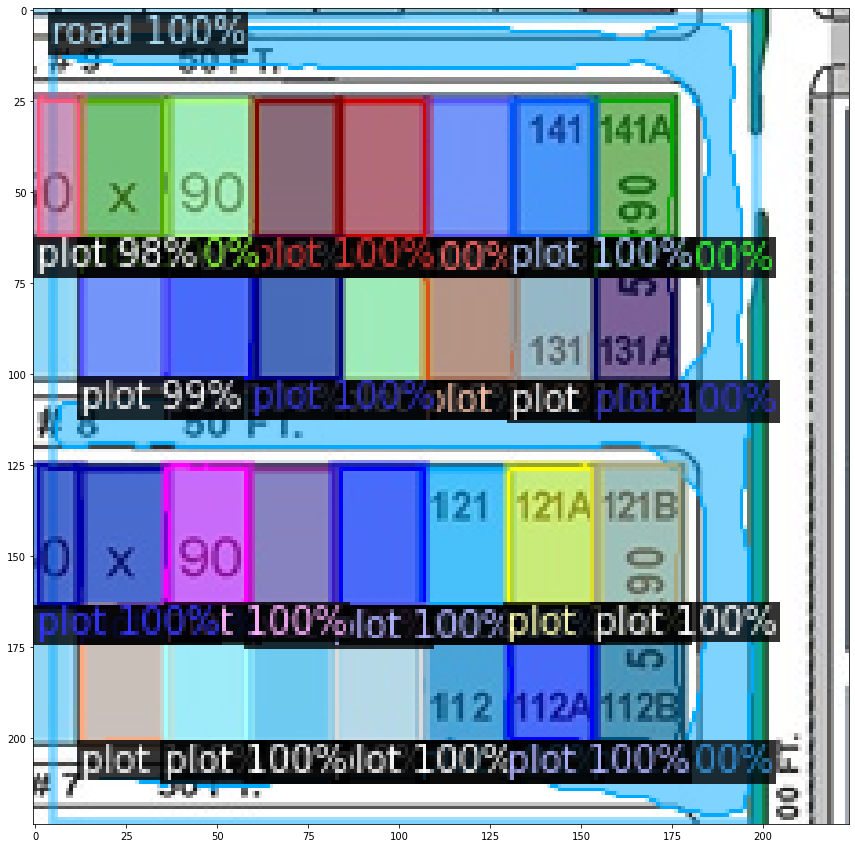

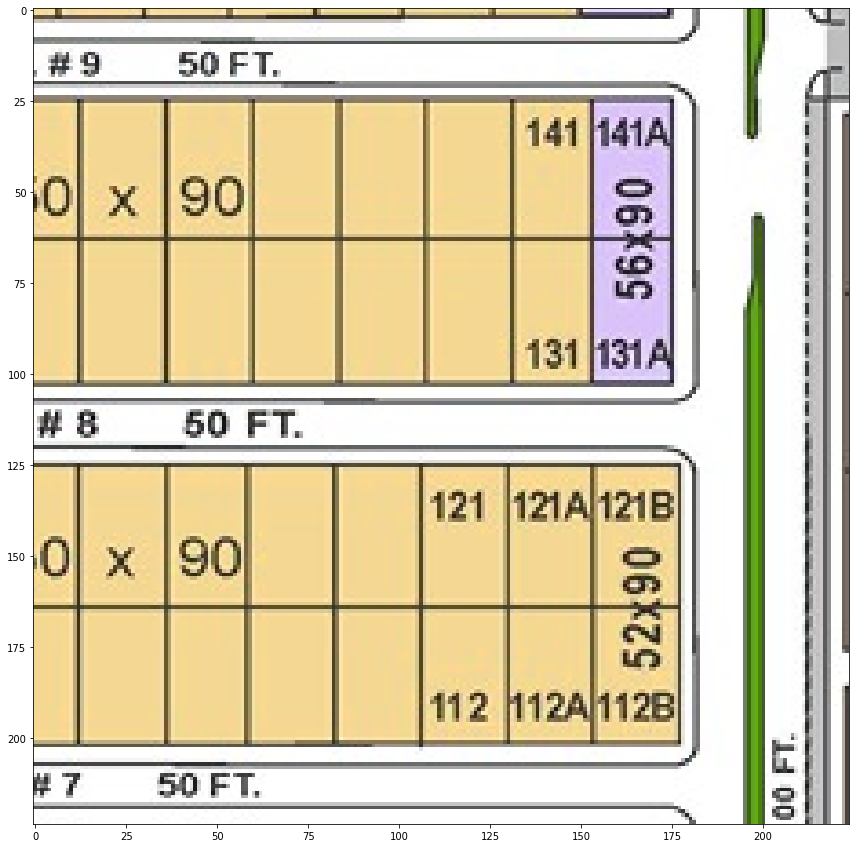

In [34]:
for d in random.sample(test_dataset_dicts, 1):
  img = cv2.imread(d["file_name"])
  outputs = predictor(img)
  pred_classes = outputs['instances'].pred_classes

  label_arr = []
  for obj in pred_classes:
      label_arr.append(classes[obj])
      

  counter = Counter(label_arr)
  print(counter)

  v = Visualizer(img[:, :, ::-1],      # convert BGR to RGB to get correct colours
                 metadata=maps_metadata,
                 scale=1,  
                 instance_mode= ColorMode.IMAGE  #  ColorMode.IMAGE_BW # removes the colours of unsegmented pixels
                 )
  v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
  plt.figure(figsize = (15, 15))
  plt.imshow(cv2.cvtColor(v.get_image()[:, :, ::-1], cv2.COLOR_BGR2RGB))
  plt.show()
  plt.figure(figsize = (15, 15))
  plt.imshow(img)
  plt.show()